In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn keras tensorflow prophet


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load CSV
data = pd.read_csv('apple_stock.csv')  # replace with your CSV filename


# Clean column names (remove leading spaces)
data.columns = data.columns.str.strip()

# Clean the prices: Remove $ sign and convert to float
for col in ['Close/Last', 'Open', 'High', 'Low']:
    data[col] = data[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

# If you have 'Volume' column and it has commas
if 'Volume' in data.columns:
    data['Volume'] = data['Volume'].replace({',': ''}, regex=True).astype(int)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# View first rows
print(data.head())


        Date  Close/Last     Volume    Open    High     Low
0 2020-02-28      273.36  106721200  257.26  278.41  256.37
1 2020-02-27      273.52   80151380  281.10  286.00  272.96
2 2020-02-26      292.65   49678430  286.53  297.88  286.50
3 2020-02-25      288.08   57668360  300.95  302.53  286.13
4 2020-02-24      298.18   55548830  297.26  304.18  289.23


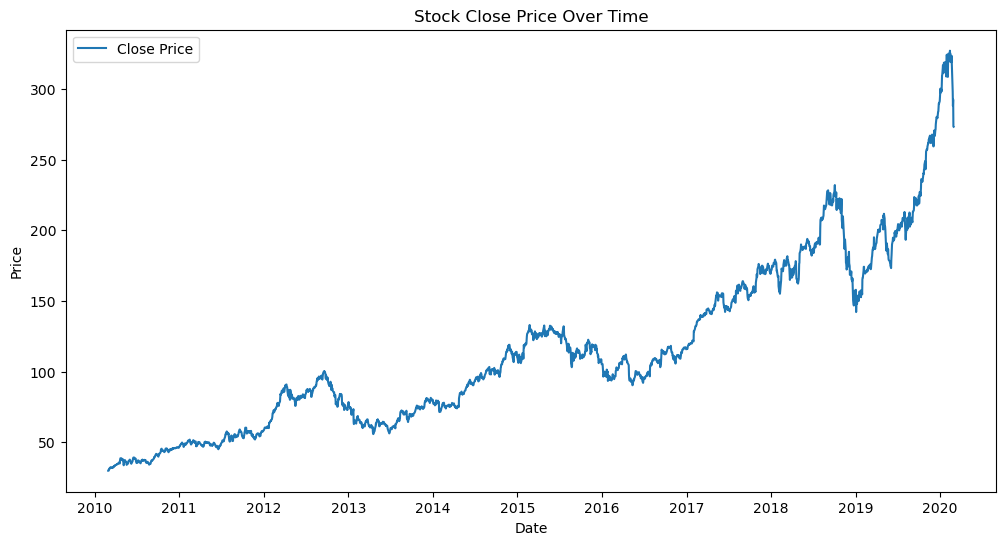

In [4]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close/Last'], label='Close Price')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [5]:
# Simple Moving Average (SMA)
data['SMA_20'] = data['Close/Last'].rolling(window=20).mean()

# Exponential Moving Average (EMA)
data['EMA_20'] = data['Close/Last'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
data['BB_upper'] = data['SMA_20'] + 2*data['Close/Last'].rolling(window=20).std()
data['BB_lower'] = data['SMA_20'] - 2*data['Close/Last'].rolling(window=20).std()

# Relative Strength Index (RSI)
delta = data['Close/Last'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Show updated data
print(data.tail())


           Date  Close/Last     Volume     Open     High      Low     SMA_20  \
2513 2010-03-05     31.2786  224647427  30.7057  31.3857  30.6614  32.403805   
2514 2010-03-04     30.1014   89591907  29.8971  30.1314  29.8043  32.223375   
2515 2010-03-03     29.9043   92846488  29.8486  29.9814  29.7057  32.040020   
2516 2010-03-02     29.8357  141486282  29.9900  30.1186  29.6771  31.847200   
2517 2010-03-01     29.8557  137312041  29.3928  29.9286  29.3500  31.680055   

         EMA_20   BB_upper   BB_lower        RSI  
2513  32.528424  33.843339  30.964271  34.037613  
2514  32.297279  33.864109  30.582641  18.522542  
2515  32.069376  33.856645  30.223395  18.294418  
2516  31.856645  33.742439  29.951961  20.424479  
2517  31.666079  33.661161  29.698949  22.960975  


In [6]:
# Use Close/Last and indicators
features = data[['Close/Last', 'SMA_20', 'EMA_20', 'RSI']].dropna()

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
features['anomaly'] = iso_forest.fit_predict(features)

# Mark anomalies
data['anomaly_iforest'] = np.nan
data.loc[features.index, 'anomaly_iforest'] = features['anomaly']

# Plot anomalies
plt.figure(figsize=(14,6))
plt.plot(data['Date'], data['Close/Last'], label='Close Price')
anomalies = data[data['anomaly_iforest'] == -1]
plt.scatter(anomalies['Date'], anomalies['Close/Last'], color='red', label='Anomaly')
plt.title('Anomalies Detected by Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
# Select Close/Last
close_prices = data['Close/Last'].values.reshape(-1,1)

# Normalize
scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close_prices)

# Create sequences
X_lstm = []
y_lstm = []
for i in range(60, len(close_scaled)):
    X_lstm.append(close_scaled[i-60:i, 0])
    y_lstm.append(close_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Reshape for LSTM
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))


In [8]:
# Build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)


Epoch 1/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 59ms/step - loss: 0.0231
Epoch 2/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 51ms/step - loss: 2.4662e-04
Epoch 3/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 58ms/step - loss: 2.4868e-04
Epoch 4/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 67ms/step - loss: 2.2626e-04
Epoch 5/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 58ms/step - loss: 2.1481e-04
Epoch 6/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 58ms/step - loss: 2.4933e-04
Epoch 7/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 56ms/step - loss: 2.3317e-04
Epoch 8/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 53ms/step - loss: 1.9749e-04
Epoch 9/10
77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 75ms/step - loss: 1.6791e-04
Epoch 10/10
7

In [9]:
predicted_prices = model.predict(X_lstm)
predicted_prices = scaler.inverse_transform(predicted_prices)

real_prices = close_prices[60:]

# Plot
plt.figure(figsize=(14,6))
plt.plot(data['Date'][60:], real_prices, label='Real Price')
plt.plot(data['Date'][60:], predicted_prices, label='Predicted Price')
plt.title('LSTM Price Prediction vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


77/77 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 44ms/step


15:31:59 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing


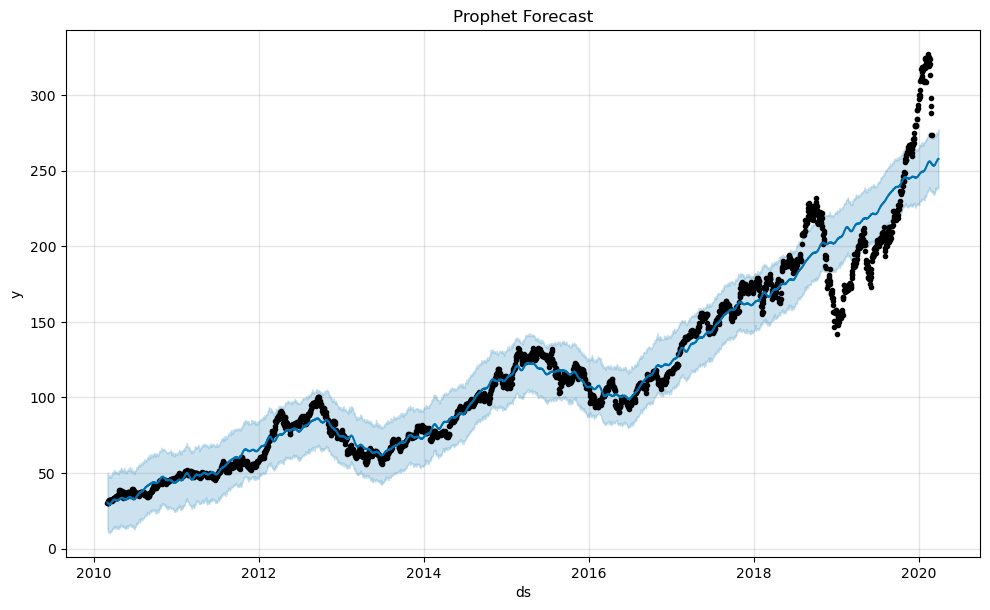

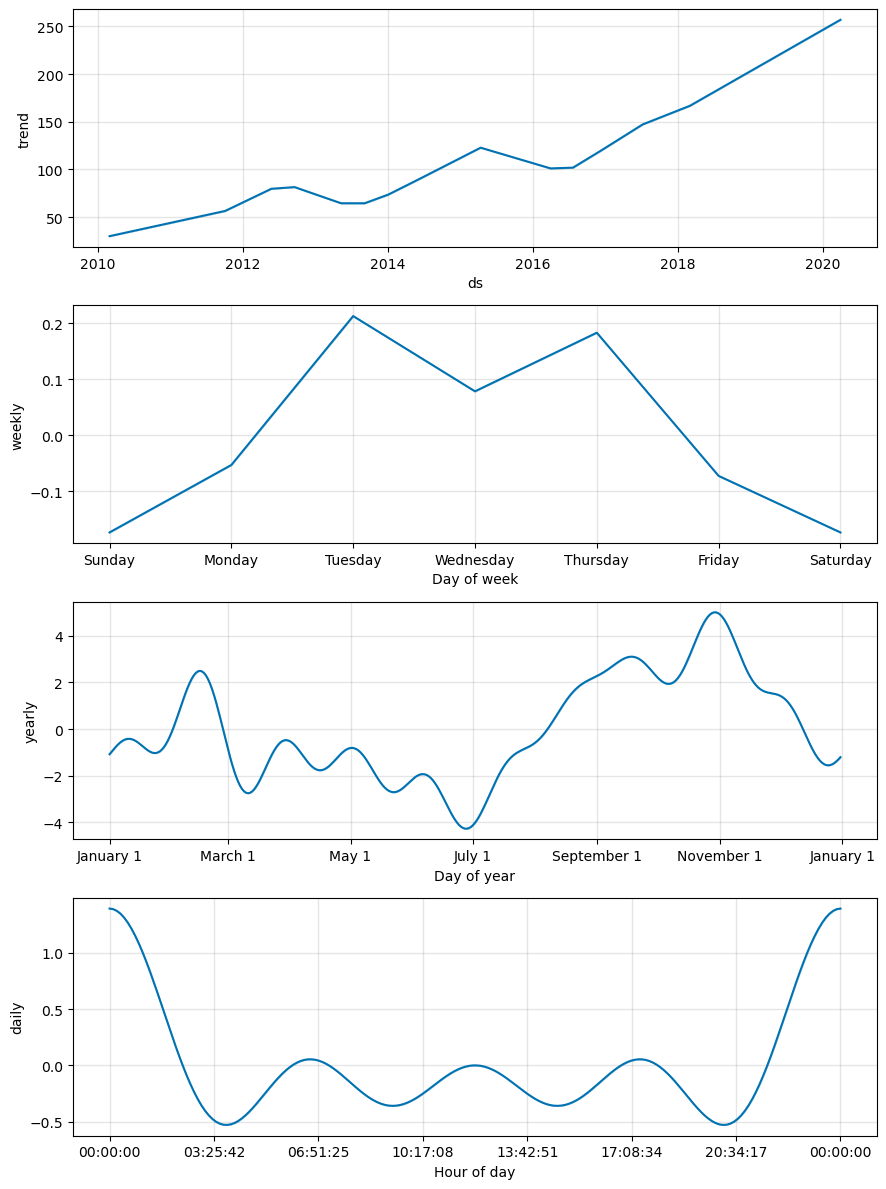

In [10]:
# Prophet needs 'ds' and 'y' columns
prophet_data = data[['Date', 'Close/Last']].rename(columns={'Date': 'ds', 'Close/Last': 'y'})

# Build and fit model
m = Prophet(daily_seasonality=True)
m.fit(prophet_data)

# Make future dataframe
future = m.make_future_dataframe(periods=30)

# Forecast
forecast = m.predict(future)

# Plot forecast
fig1 = m.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Plot components
fig2 = m.plot_components(forecast)
plt.show()


In [11]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# --- Streamlit Page Config ---
st.set_page_config(page_title="Stock Price Anomaly Detection", layout="wide")

# --- Title ---
st.title("üìà Financial Time-Series Anomaly Detection")

# --- File Upload ---
uploaded_file = st.file_uploader("Upload a Stock CSV file", type=['csv'])

if uploaded_file:
    # Read CSV
    df = pd.read_csv(uploaded_file)

    # --- Preprocessing ---
    df.columns = df.columns.str.strip()  # Remove spaces from column names
    df['Close/Last'] = df['Close/Last'].replace('[\$,]', '', regex=True).astype(float)  # Remove $ and convert to float
    df['Open'] = df['Open'].replace('[\$,]', '', regex=True).astype(float)
    df['High'] = df['High'].replace('[\$,]', '', regex=True).astype(float)
    df['Low'] = df['Low'].replace('[\$,]', '', regex=True).astype(float)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # --- Feature Engineering ---
    df['SMA_20'] = df['Close/Last'].rolling(window=20).mean()
    df['EMA_20'] = df['Close/Last'].ewm(span=20, adjust=False).mean()

    # RSI Calculation
    delta = df['Close/Last'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Bollinger Bands
    df['BB_upper'] = df['SMA_20'] + 2 * df['Close/Last'].rolling(window=20).std()
    df['BB_lower'] = df['SMA_20'] - 2 * df['Close/Last'].rolling(window=20).std()

    # --- Anomaly Detection ---
    features = ['Close/Last', 'SMA_20', 'EMA_20', 'RSI']
    df_anomaly = df.dropna(subset=features)  # Drop rows with NaN
    scaler = StandardScaler()
    X = scaler.fit_transform(df_anomaly[features])

    model = IsolationForest(contamination=0.02, random_state=42)
    df_anomaly['anomaly'] = model.fit_predict(X)
    df_anomaly['anomaly'] = df_anomaly['anomaly'].map({1: 0, -1: 1})  # 1 for anomaly

    # --- Visualization ---
    st.subheader("üìä Stock Price with Anomalies")

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df_anomaly['Date'], df_anomaly['Close/Last'], label='Close Price')
    ax.scatter(df_anomaly[df_anomaly['anomaly'] == 1]['Date'],
               df_anomaly[df_anomaly['anomaly'] == 1]['Close/Last'],
               color='red', label='Anomaly', marker='x', s=100)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Stock Price with Detected Anomalies')
    ax.legend()
    st.pyplot(fig)

    st.subheader("üìÑ Raw Data with Anomaly Labels")
    st.dataframe(df_anomaly)

else:
    st.info("Please upload a CSV file to get started.")


Overwriting app.py


In [ ]:
!streamlit run app.py